images.shape: (106, 100, 100, 3)
poses.shape: (106, 4, 4)
focal: 138.88887889922103


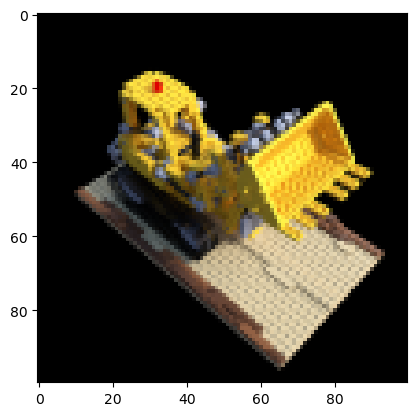

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
from tqdm import tqdm

#“npz”数据包含相机的焦距、相机拍摄的图像和相机拍摄时的姿势
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

device = torch.device("cuda")
torch.manual_seed(999) #通过指定seed值，可以保证每次执行 torch.manual_seed()后生成的随机数都相同
np.random.seed(666)
torch.backends.cudnn.benchmark=True #提升卷积神经网络的运行速度
#加载数据，位姿，焦距
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print("images.shape:", images.shape)
print("poses.shape:", poses.shape)
print("focal:", focal)

n_train = 100 # use n_train images for training

test_img, test_pose = images[101], poses[101]
images = images[:n_train]
poses = poses[:n_train]

plt.imshow(test_img)
plt.show()

In [3]:

class NeRF(nn.Module):
    #
    def __init__(self, D=8, W=256, input_ch=60, input_ch_views=24, skip=4, use_view_dirs=True):
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skip = skip
        self.use_view_dirs = use_view_dirs

        self.net = nn.ModuleList([nn.Linear(input_ch, W)])
        for i in range(D-1):
            if i == skip:
                self.net.append(nn.Linear(W + input_ch, W))
            else:
                self.net.append(nn.Linear(W, W))

        self.alpha_linear = nn.Linear(W, 1)
        self.feature_linear = nn.Linear(W, W)
        if use_view_dirs:
            self.proj = nn.Linear(W + input_ch_views, W // 2)
        else:
            self.proj = nn.Linear(W, W // 2)
        self.rgb_linear = nn.Linear(W // 2, 3)

    def forward(self, input_pts, input_views=None):
        h = input_pts.clone()
        for i, _ in enumerate(self.net):
            h = F.relu(self.net[i](h))
            if i == self.skip:
                h = torch.cat([input_pts, h], -1)

        alpha = F.relu(self.alpha_linear(h))
        feature = self.feature_linear(h)

        if self.use_view_dirs:
            h = torch.cat([feature, input_views], -1)

        h = F.relu(self.proj(h))
        rgb = torch.sigmoid(self.rgb_linear(h))

        return rgb, alpha

net = NeRF(use_view_dirs=True)
print(net)


NeRF(
  (net): ModuleList(
    (0): Linear(in_features=60, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Linear(in_features=316, out_features=256, bias=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=256, bias=True)
  )
  (alpha_linear): Linear(in_features=256, out_features=1, bias=True)
  (feature_linear): Linear(in_features=256, out_features=256, bias=True)
  (proj): Linear(in_features=280, out_features=128, bias=True)
  (rgb_linear): Linear(in_features=128, out_features=3, bias=True)
)


In [4]:
def PE(x, L):#位置编码 低频信息转换为高频信息-  x代表输入给编码器的数据维度，也就是3，2,5， l为数学公式中的L
    #这个函数对x坐标的3个值和向量d 的2个值都进行了编码。实验中设置了 L=10 for y(x)，L=4 for y（d）
#这里为了方便统一处理，应该会影响最后效果
  pai = 3.14
  pe = []
  for i in range(L):
    for fn in [torch.sin, torch.cos]:#依次 先后读取sin cos 函数
      pe.append(fn(2.**i * x * pai))
  return torch.cat(pe, -1)  #对tensor 进行拼接

In [5]:
def sample_rays_np(H, W, f, c2w):#
    i, j = np.meshgrid(np.arange(W, dtype=np.float32), np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5+.5)/f, -(j-H*.5+.5)/f, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., None, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
    return rays_o, rays_d

In [6]:
def uniform_sample_point(tn, tf, N_samples, device): # 归一化 采样的点，可以理解为把光线的原点移到near平面
    k = torch.rand([N_samples], device=device) / float(N_samples)
    pt_value = torch.linspace(0.0, 1.0, N_samples + 1, device=device)[:-1]
    pt_value += k
    return tn + (tf - tn) * pt_value

In [7]:
# Hierarchical sampling (section 5.2)
#大概步骤 1根据pdf 求 cdf 2 做0-1的均匀采样 3求采样点值在cdf中的对应分块和传播时间 4求解采样点对应的z_vals
def sample_pdf_point(bins, weights, N_samples, device):
    pdf = F.normalize(weights, p=1, dim=-1)
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.cat([torch.zeros_like(cdf[..., :1]), cdf], -1)

    # uniform sampling
    u = torch.rand(list(cdf.shape[:-1]) + [N_samples], device=device).contiguous()

    # invert
    ids = torch.searchsorted(cdf, u, right=True)
    below = torch.max(torch.zeros_like(ids - 1, device=device), ids - 1)
    above = torch.min((cdf.shape[-1] - 1) * torch.ones_like(ids, device=device), ids)
    ids_g = torch.stack([below, above], -1)
    # ids_g => (batch, N_samples, 2)

    # matched_shape : [batch, N_samples, bins]
    matched_shape = [ids_g.shape[0], ids_g.shape[1], cdf.shape[-1]]
    # gather cdf value
    cdf_val = torch.gather(cdf.unsqueeze(1).expand(matched_shape), -1, ids_g)
    # gather z_val
    bins_val = torch.gather(bins[None, None, :].expand(matched_shape), -1, ids_g)

    # get z_val for the fine sampling
    cdf_d = (cdf_val[..., 1] - cdf_val[..., 0])
    cdf_d = torch.where(cdf_d < 1e-5, torch.ones_like(cdf_d, device=device), cdf_d)
    t = (u - cdf_val[..., 0]) / cdf_d
    samples = bins_val[..., 0] + t * (bins_val[..., 1] - bins_val[..., 0])

    return samples

In [8]:
def get_rgb_w(net, pts, rays_d, z_vals, device, noise_std=.0, use_view=False):
    # pts => tensor(Batch_Size, uniform_N, 3)
    # rays_d => tensor(Batch_Size, 3)
    # Run network
    pts_flat = torch.reshape(pts, [-1, 3])
    pts_flat = PE(pts_flat, L=10)
    dir_flat = None
    if use_view:
        dir_flat = F.normalize(torch.reshape(rays_d.unsqueeze(-2).expand_as(pts), [-1, 3]), p=2, dim=-1)
        dir_flat = PE(dir_flat, L=4)

    rgb, sigma = net(pts_flat, dir_flat)
    rgb = rgb.view(list(pts.shape[:-1]) + [3])
    sigma = sigma.view(list(pts.shape[:-1]))

    # get the interval
    delta = z_vals[..., 1:] - z_vals[..., :-1]
    INF = torch.ones(delta[..., :1].shape, device=device).fill_(1e10)
    delta = torch.cat([delta, INF], -1)
    delta = delta * torch.norm(rays_d, dim=-1, keepdim=True)

    # add noise to sigma
    if noise_std > 0.:
        sigma += torch.randn(sigma.size(), device=device) * noise_std

    # get weights
    alpha = 1. - torch.exp(-sigma * delta)
    ones = torch.ones(alpha[..., :1].shape, device=device)
    weights = alpha * torch.cumprod(torch.cat([ones, 1. - alpha], dim=-1), dim=-1)[..., :-1]

    return rgb, weights

In [9]:
def render_rays(net, rays, bound, N_samples, device, noise_std=.0, use_view=False):
    rays_o, rays_d = rays
    bs = rays_o.shape[0]
    near, far = bound
    uniform_N, important_N = N_samples
    z_vals = uniform_sample_point(near, far, uniform_N, device)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., None]
    # pts => tensor(Batch_Size, uniform_N, 3)
    # rays_o, rays_d => tensor(Batch_Size, 3)

    # Run network
    if important_N is not None:
        with torch.no_grad():
            rgb, weights = get_rgb_w(net, pts, rays_d, z_vals, device, noise_std=noise_std, use_view=use_view)
            z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
            samples = sample_pdf_point(z_vals_mid, weights[..., 1:-1], important_N, device)

        z_vals = z_vals.unsqueeze(0).expand([bs, uniform_N])
        z_vals, _ = torch.sort(torch.cat([z_vals, samples], dim=-1), dim=-1)
        pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., None]

    rgb, weights = get_rgb_w(net, pts, rays_d, z_vals, device, noise_std=noise_std, use_view=use_view)

    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)
    depth_map = torch.sum(weights * z_vals, -1)
    acc_map = torch.sum(weights, -1)

    return rgb_map, depth_map, acc_map

In [10]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


1.13.0+cu116
True


In [11]:
print("Process rays data!")
rays_o_list = list()
rays_d_list = list()
rays_rgb_list = list()

for i in range(n_train):
    img = images[i]
    pose = poses[i]
    rays_o, rays_d = sample_rays_np(H, W, focal, pose)

    rays_o_list.append(rays_o.reshape(-1, 3))
    rays_d_list.append(rays_d.reshape(-1, 3))
    rays_rgb_list.append(img.reshape(-1, 3))

rays_o_npy = np.concatenate(rays_o_list, axis=0)
rays_d_npy = np.concatenate(rays_d_list, axis=0)
rays_rgb_npy = np.concatenate(rays_rgb_list, axis=0)
rays = torch.tensor(np.concatenate([rays_o_npy, rays_d_npy, rays_rgb_npy], axis=1), device=device)
# rays => tensor(N_rays, 9) => o+d+rgb

Process rays data!


There are 976 batches of rays and each batch contains 1024 rays


Epoch 1: 100%|██████████████████████████████████████| 976/976 [01:25<00:00, 11.42it/s, loss=0.04302]


PSNR=12.552553176879883


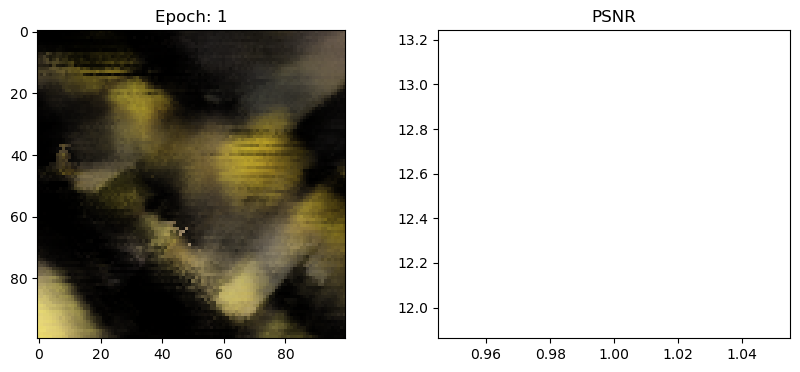

Epoch 2: 100%|██████████████████████████████████████| 976/976 [01:24<00:00, 11.52it/s, loss=0.03353]


PSNR=12.816436767578125


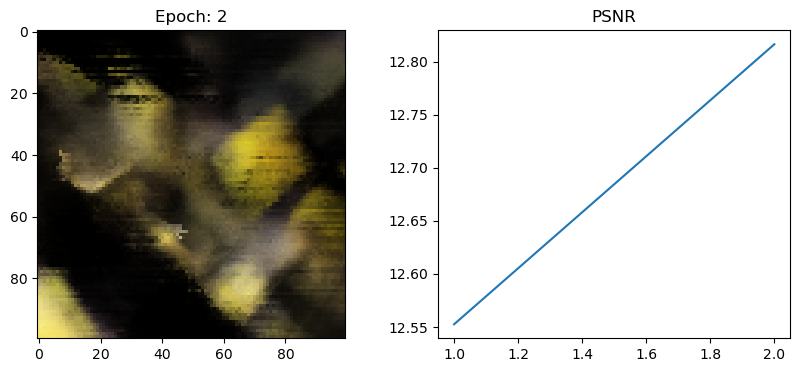

Epoch 3: 100%|██████████████████████████████████████| 976/976 [01:25<00:00, 11.39it/s, loss=0.02658]


PSNR=12.26878833770752


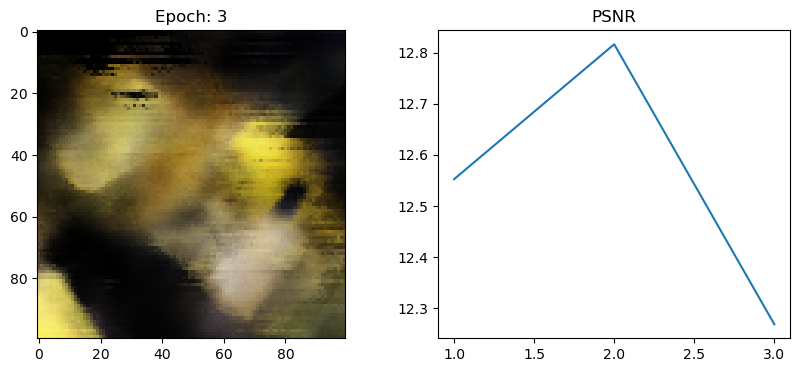

Epoch 4: 100%|██████████████████████████████████████| 976/976 [01:25<00:00, 11.36it/s, loss=0.01858]


PSNR=12.223777770996094


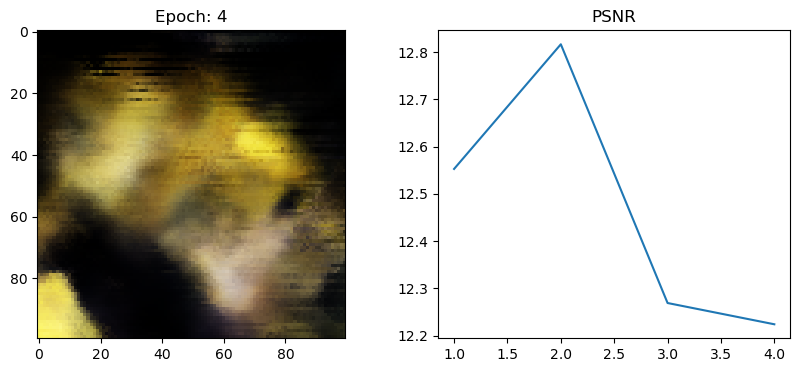

Epoch 5: 100%|██████████████████████████████████████| 976/976 [01:23<00:00, 11.67it/s, loss=0.01512]


PSNR=12.166641235351562


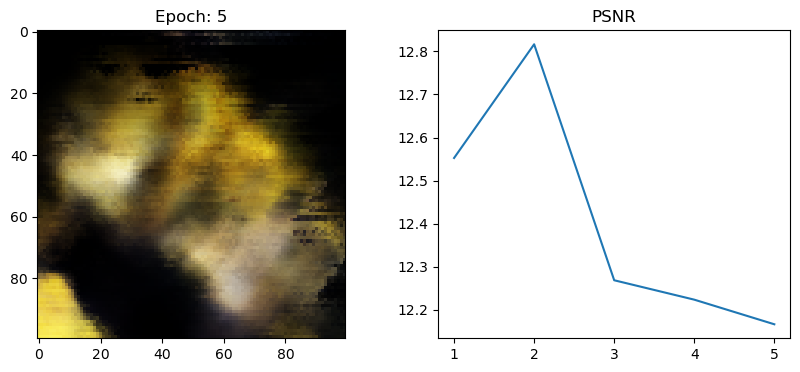

Epoch 6: 100%|██████████████████████████████████████| 976/976 [01:24<00:00, 11.59it/s, loss=0.01472]


PSNR=12.164051055908203


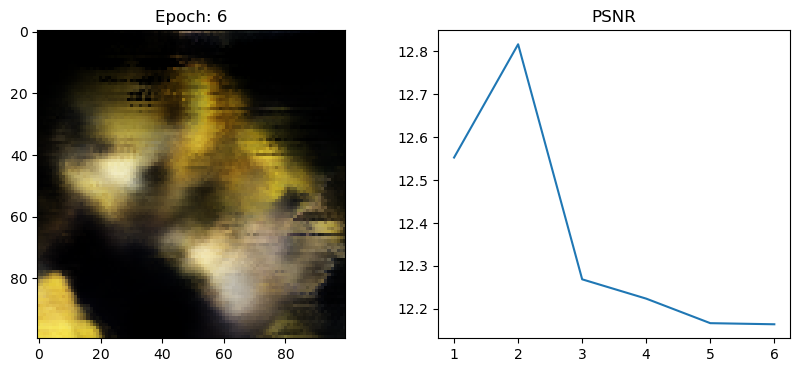

Epoch 7: 100%|██████████████████████████████████████| 976/976 [01:23<00:00, 11.66it/s, loss=0.01163]


PSNR=11.488058090209961


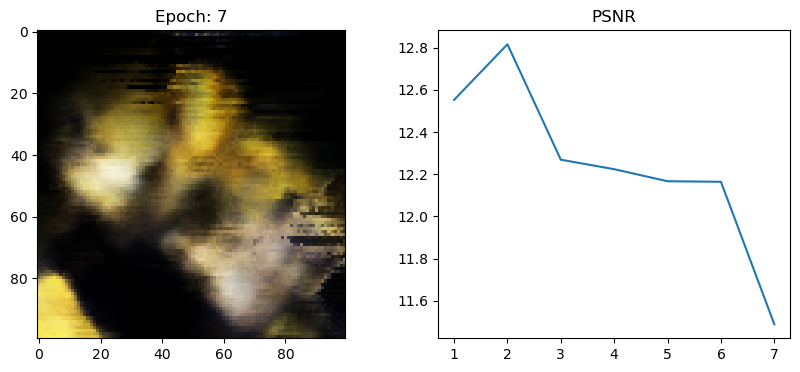

Epoch 8: 100%|██████████████████████████████████████| 976/976 [01:23<00:00, 11.65it/s, loss=0.01335]


PSNR=11.966889381408691


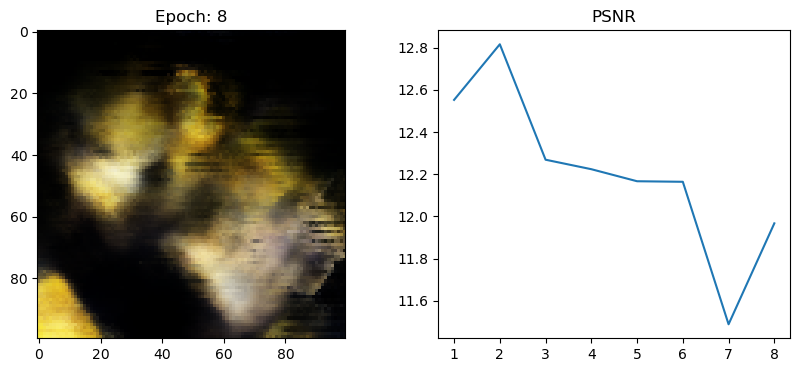

Epoch 9: 100%|██████████████████████████████████████| 976/976 [01:23<00:00, 11.69it/s, loss=0.01272]


PSNR=11.701629638671875


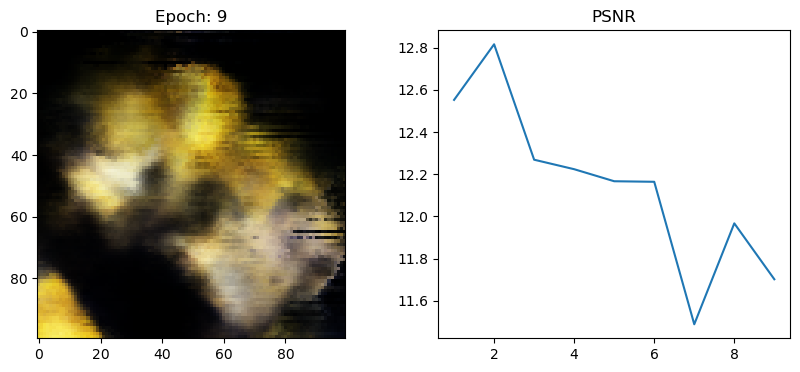

Epoch 10: 100%|█████████████████████████████████████| 976/976 [01:24<00:00, 11.59it/s, loss=0.00962]


PSNR=11.500712394714355


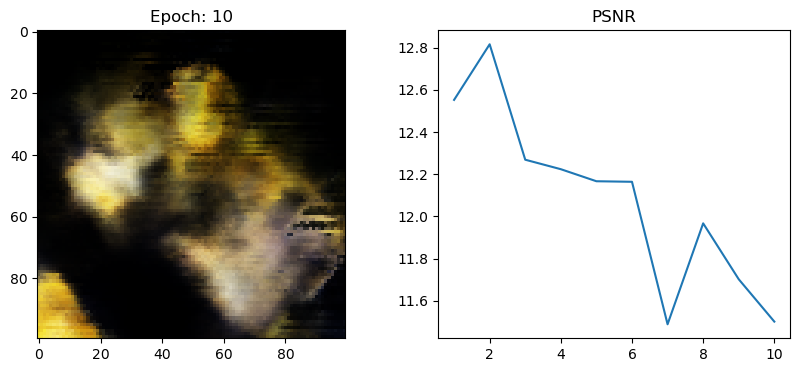

Done
NeRF(
  (net): ModuleList(
    (0): Linear(in_features=60, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Linear(in_features=316, out_features=256, bias=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=256, bias=True)
  )
  (alpha_linear): Linear(in_features=256, out_features=1, bias=True)
  (feature_linear): Linear(in_features=256, out_features=256, bias=True)
  (proj): Linear(in_features=280, out_features=128, bias=True)
  (rgb_linear): Linear(in_features=128, out_features=3, bias=True)
)


In [12]:
#############################
# training parameters
#############################   Batch_size = 4096
N = rays.shape[0]
Batch_size = 1024
iterations = N // Batch_size
print(f"There are {iterations} batches of rays and each batch contains {Batch_size} rays")

bound = (2., 6.)
N_samples = (64, None)
use_view = True
epoch = 10
psnr_list = []
e_nums = []

#############################
# test data
#############################
test_rays_o, test_rays_d = sample_rays_np(H, W, focal, test_pose)
test_rays_o = torch.tensor(test_rays_o, device=device)
test_rays_d = torch.tensor(test_rays_d, device=device)
test_rgb = torch.tensor(test_img, device=device)


#############################
# training
#############################
net = NeRF(use_view_dirs=use_view).to(device)
optimizer = torch.optim.Adam(net.parameters(), 5e-4)
mse = torch.nn.MSELoss()

for e in range(epoch):
    # create iteration for training
    rays = rays[torch.randperm(N), :]
    train_iter = iter(torch.split(rays, Batch_size, dim=0))

    # render + mse
    with tqdm(total=iterations, desc=f"Epoch {e+1}", ncols=100) as p_bar:
        for i in range(iterations):
            train_rays = next(train_iter)
            assert train_rays.shape == (Batch_size, 9)

            rays_o, rays_d, target_rgb = torch.chunk(train_rays, 3, dim=-1)
            rays_od = (rays_o, rays_d)
            rgb, _, __ = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)

            loss = mse(rgb, target_rgb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            p_bar.set_postfix({'loss': '{0:1.5f}'.format(loss.item())})
            p_bar.update(1)

    with torch.no_grad():
        rgb_list = list()
        for j in range(test_rays_o.shape[0]):
            rays_od = (test_rays_o[j], test_rays_d[j])
            rgb, _, __ = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)
            rgb_list.append(rgb.unsqueeze(0))
        rgb = torch.cat(rgb_list, dim=0)
        loss = mse(rgb, torch.tensor(test_img, device=device)).cpu()
        psnr = -10. * torch.log(loss).item() / torch.log(torch.tensor([10.]))
        print(f"PSNR={psnr.item()}")
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb.cpu().detach().numpy())
        plt.title(f'Epoch: {e + 1}')
        plt.subplot(122)

        e_nums.append(e+1)
        psnr_list.append(psnr.numpy())
        plt.plot(e_nums, psnr_list)
        plt.title('PSNR')
        plt.show()

print('Done')
net = NeRF(use_view_dirs=True)
print(net)

In [13]:
from ipywidgets import interactive, widgets


trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=float)

rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=float)

rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=float)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = sample_rays_np(H, W, focal, c2w[:3,:4])
    with torch.no_grad():
      rays_o = torch.tensor(rays_o, device=device)
      rays_d = torch.tensor(rays_d, device=device)
      rgb_list = list()
      for j in range(rays_o.shape[0]):
        rays_od = (rays_o[j], rays_d[j])
        rgb, _, __ = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)
        rgb_list.append(rgb.unsqueeze(0))
      rgb = torch.cat(rgb_list, dim=0)

    plt.figure(2, figsize=(20,6))
    plt.imshow(rgb.cpu().detach().numpy())
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

# interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot

In [17]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    with torch.no_grad():
      c2w = pose_spherical(th, -30., 4.)
      rays_o, rays_d = sample_rays_np(H, W, focal, c2w[:3,:4])
      rays_od = (torch.tensor(rays_o, device=device,dtype=torch.float32),torch.tensor(rays_d, device=device,dtype=torch.float32))
      rgb, depth, acc = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)
    frames.append((255*np.clip(rgb.cpu().numpy(),0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

100%|██████████| 120/120 [00:38<00:00,  3.14it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (100, 100) to (112, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [19]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)